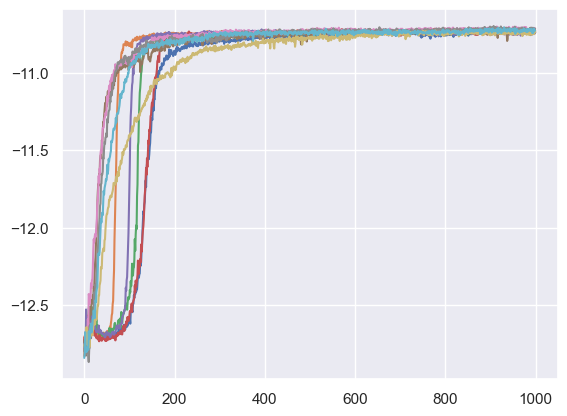

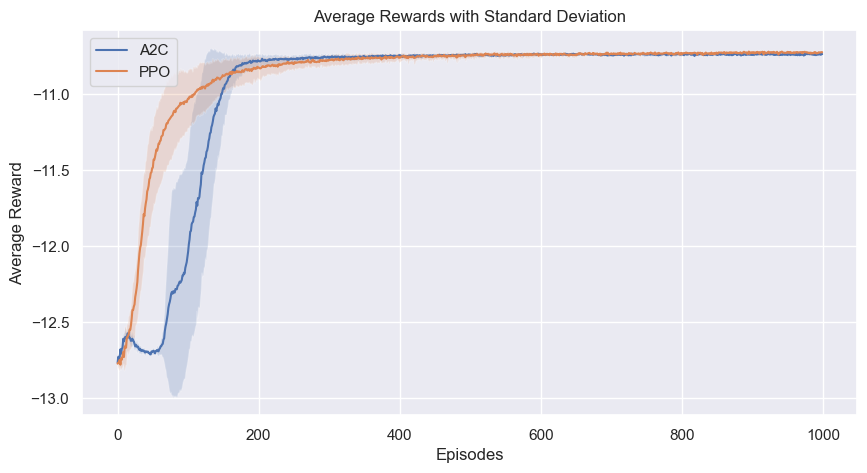

A2C Costs: Mean = 158590.65593734942, CI = (158215.65714559372, 158965.65472910512)
PPO Costs: Mean = 160628.34593834943, CI = (157273.1725558454, 163983.51932085346)


In [1]:
import os
import gym
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from environments.energy_management_env import EnergyManagementEnv
from environments.env_registration import register_env
from rl_monitoring_utils.vectorized_env_wrapper import VectorizedEnvWrapper
from policies.categorical_policy import CategoricalPolicy
from learning_utils.value_estimator import ValueEstimator
from agents.a2c import A2C
from agents.ppo import PPO

# Define and register the environment
env_params = {
    'SOC_min': 0.2,
    'SOC_max': 0.8,
    'E': 5000,
    'lambda_val': 0.1,
    'data_path': 'data/Data_input.csv',
    'initial_SOC': 0.5
}

register_env('EnergyManagement-v0', 'environments.env_registration:environment_creator',{'environment_class': EnergyManagementEnv, **env_params})

# Function to train, evaluate, and save an agent's results immediately
def train_and_evaluate(agent_class, config, num_runs=5, agent_name=''):
    os.makedirs(f'results/{agent_name}', exist_ok=True)
    rewards_collected = []
    costs_collected = []
    for i in range(num_runs):
        env = VectorizedEnvWrapper(gym.make("EnergyManagement-v0"), num_envs=8)
        policy = CategoricalPolicy(env, lr=1e-2)
        value_estimator = ValueEstimator(env, lr=1e-2)
        agent, total_rewards = agent_class(env, policy, value_estimator, **config)
        env_test = VectorizedEnvWrapper(gym.make("EnergyManagement-v0"), num_envs=1)
        cost = env_test.test_agent(agent) * -1
        result = (total_rewards, cost)
        
        # Save results after computation
        with open(f'results/{agent_name}/run_{i+1}.pkl', 'wb') as f:
            pickle.dump(result, f)
        
        # Collect data for plotting and analysis
        rewards_collected.append(total_rewards)
        costs_collected.append(cost)
    
    return rewards_collected, costs_collected

# Training configurations
a2c_config = {'epochs': 1000, 'gamma': 1, 'T': 720}
ppo_config = {'epochs': 1000, 'gamma': 1, 'T': 720}

# Train and save A2C and PPO agent results
a2c_rewards, a2c_costs = train_and_evaluate(A2C, a2c_config, num_runs=5, agent_name='a2c')
ppo_rewards, ppo_costs = train_and_evaluate(PPO, ppo_config, num_runs=5, agent_name='ppo')

# Plotting function for rewards
def plot_results(rewards, label):
    means = np.mean(rewards, axis=0)
    std_devs = np.std(rewards, axis=0)
    episodes = np.arange(len(means))
    plt.fill_between(episodes, means - std_devs, means + std_devs, alpha=0.2)
    plt.plot(episodes, means, label=label)

plt.figure(figsize=(10, 5))
plot_results(a2c_rewards, 'A2C')
plot_results(ppo_rewards, 'PPO')
plt.title('Average Rewards with Standard Deviation')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

# Compute and print the 99% confidence interval for costs
def compute_confidence_interval(costs):
    mean = np.mean(costs)
    sem = np.std(costs, ddof=1) / np.sqrt(len(costs))
    ci = t.ppf(0.995, df=len(costs)-1) * sem
    return mean, mean - ci, mean + ci

a2c_ci = compute_confidence_interval(a2c_costs)
ppo_ci = compute_confidence_interval(ppo_costs)
print(f"A2C Costs: Mean = {a2c_ci[0]}, CI = ({a2c_ci[1]}, {a2c_ci[2]})")
print(f"PPO Costs: Mean = {ppo_ci[0]}, CI = ({ppo_ci[1]}, {ppo_ci[2]})")


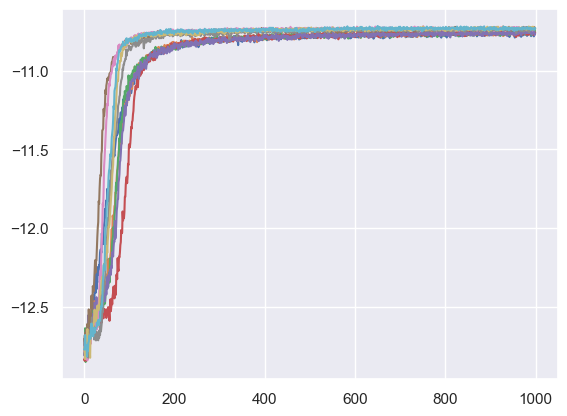

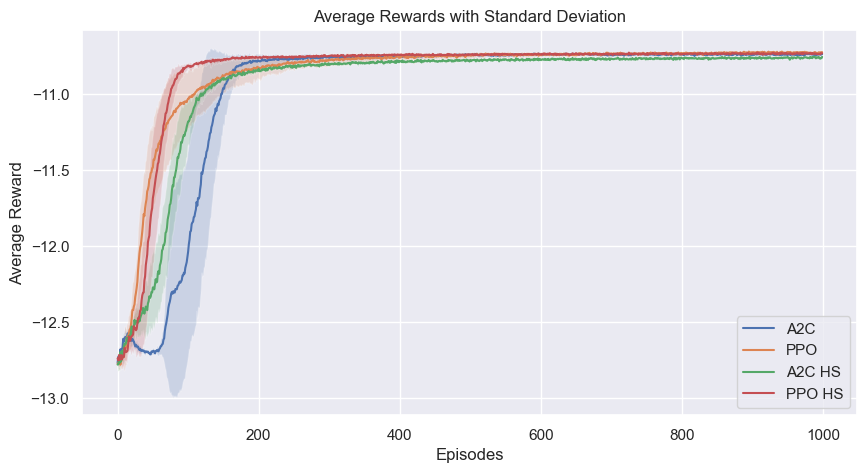

In [4]:

# Function to train, evaluate, and save an agent's results immediately
def train_and_evaluate_hs(agent_class, config, hidden_sizes=[], num_runs=5, agent_name=''):
    os.makedirs(f'results/{agent_name}', exist_ok=True)
    rewards_collected = []
    costs_collected = []
    for i in range(num_runs):
        env = VectorizedEnvWrapper(gym.make("EnergyManagement-v0"), num_envs=8)
        policy = CategoricalPolicy(env, lr=1e-2, hidden_sizes=hidden_sizes)
        value_estimator = ValueEstimator(env, lr=1e-2)
        agent, total_rewards = agent_class(env, policy, value_estimator, **config)
        env_test = VectorizedEnvWrapper(gym.make("EnergyManagement-v0"), num_envs=1)
        cost = env_test.test_agent(agent) * -1
        result = (total_rewards, cost)
        
        # Save results after computation
        with open(f'results/{agent_name}/run_{i+1}.pkl', 'wb') as f:
            pickle.dump(result, f)
        
        # Collect data for plotting and analysis
        rewards_collected.append(total_rewards)
        costs_collected.append(cost)
    
    return rewards_collected, costs_collected

# Training configurations with hidden_sizes modification for comparison
hidden_sizes = []
a2c_rewards_hs, a2c_costs_hs = train_and_evaluate_hs(A2C, a2c_config, hidden_sizes, num_runs=5, agent_name='a2c_hs')
ppo_rewards_hs, ppo_costs_hs = train_and_evaluate_hs(PPO, ppo_config, hidden_sizes, num_runs=5, agent_name='ppo_hs')

# Plotting function for rewards including hidden sizes variants
plt.figure(figsize=(10, 5))
plot_results(a2c_rewards, 'A2C')
plot_results(ppo_rewards, 'PPO')
plot_results(a2c_rewards_hs, 'A2C HS')
plot_results(ppo_rewards_hs, 'PPO HS')
plt.title('Average Rewards with Standard Deviation')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.legend()
plt.show()


In [5]:
print(f" A2C Costs: Mean = {a2c_ci[0]}, CI = ({a2c_ci[1]}, {a2c_ci[2]})")
print(f" PPO Costs: Mean = {ppo_ci[0]}, CI = ({ppo_ci[1]}, {ppo_ci[2]})")
a2c_ci_hs = compute_confidence_interval(a2c_costs_hs)
ppo_ci_hs = compute_confidence_interval(ppo_costs_hs)
print(f"A2C HS Costs: Mean = {a2c_ci_hs[0]}, CI = ({a2c_ci_hs[1]}, {a2c_ci_hs[2]})")
print(f"PPO HS Costs: Mean = {ppo_ci_hs[0]}, CI = ({ppo_ci_hs[1]}, {ppo_ci_hs[2]})")

 A2C Costs: Mean = 158590.65593734942, CI = (158215.65714559372, 158965.65472910512)
 PPO Costs: Mean = 160628.34593834943, CI = (157273.1725558454, 163983.51932085346)
A2C HS Costs: Mean = 158865.98594934942, CI = (158200.80542077858, 159531.16647792025)
PPO HS Costs: Mean = 158977.26594934944, CI = (158588.23063205986, 159366.30126663903)
